In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
import numpy as np
from data_ingestion import fetch_stock_data

In [73]:
# Define the time period for analysis

short_window = 50 # 50 days window
long_window = 200 # 200 days window

# Define the tickers and date range
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")
tickers = ['AAPL', 'TSLA', 'GOOGL', 'MSFT']


stock_data = fetch_stock_data(tickers, start_date, end_date)
stock_data.head()

[*********************100%***********************]  4 of 4 completed


Attribute,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2024-08-12,AAPL,216.768036,217.529999,219.509995,215.600006,216.070007,38028100.0
1,2024-08-12,GOOGL,161.507645,162.289993,164.899994,161.839996,164.350006,15895300.0
2,2024-08-12,MSFT,403.714752,406.809998,408.760010,404.239990,407.059998,16762900.0
3,2024-08-12,TSLA,197.490005,197.490005,199.259995,194.669998,199.020004,64044900.0
4,2024-08-13,AAPL,220.494934,221.270004,221.889999,219.009995,219.009995,44155300.0


In [74]:
unique_tickers = stock_data['Ticker'].unique()
unique_tickers

array(['AAPL', 'GOOGL', 'MSFT', 'TSLA'], dtype=object)

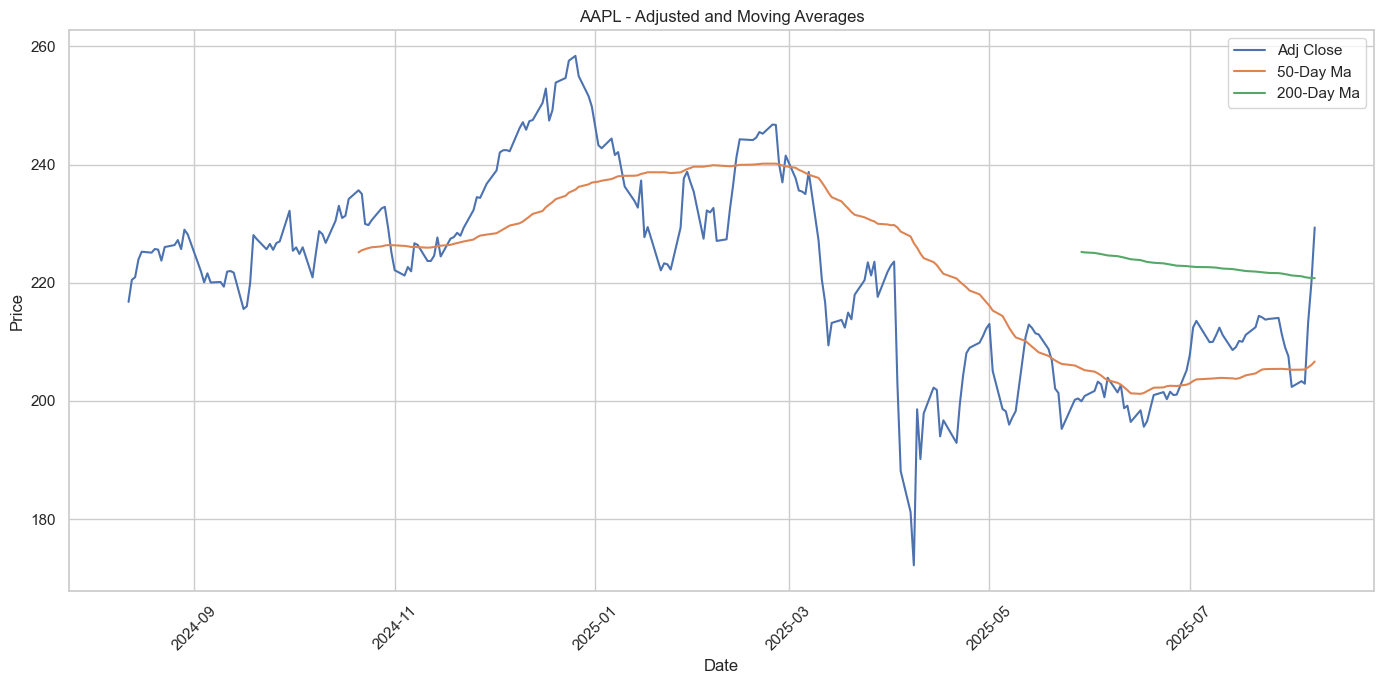

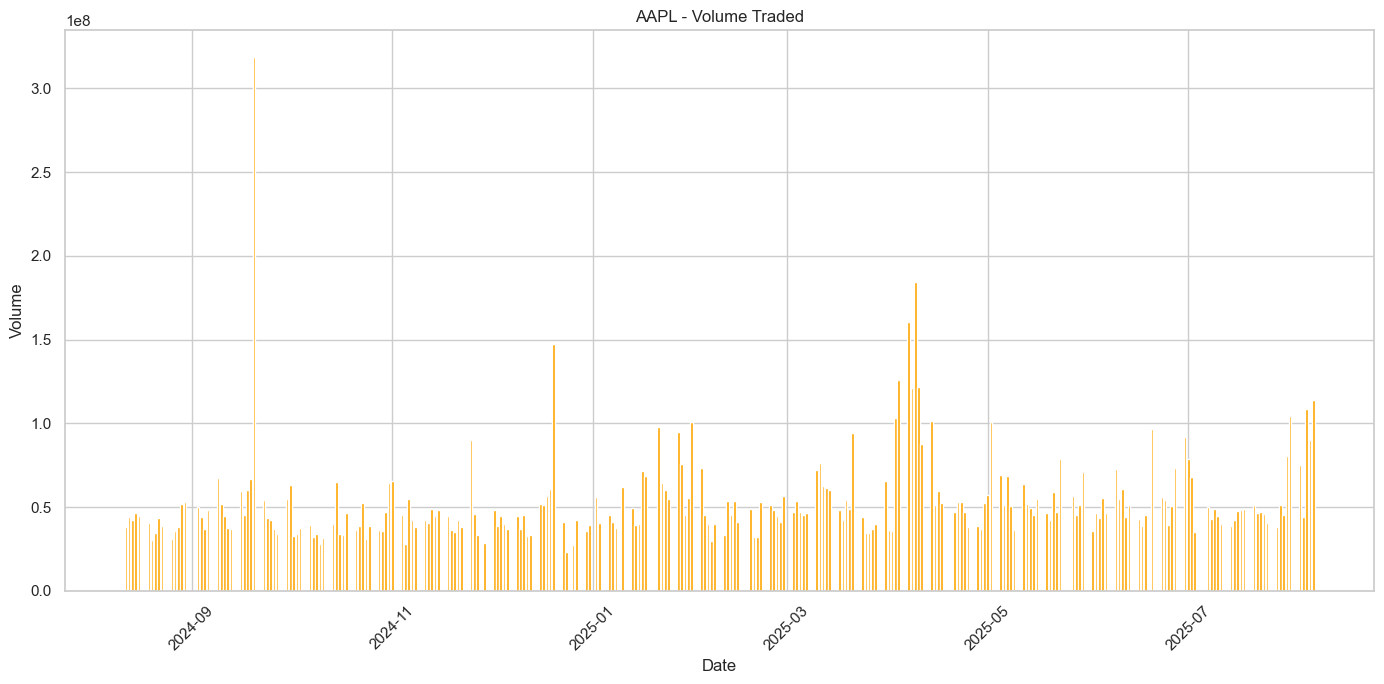

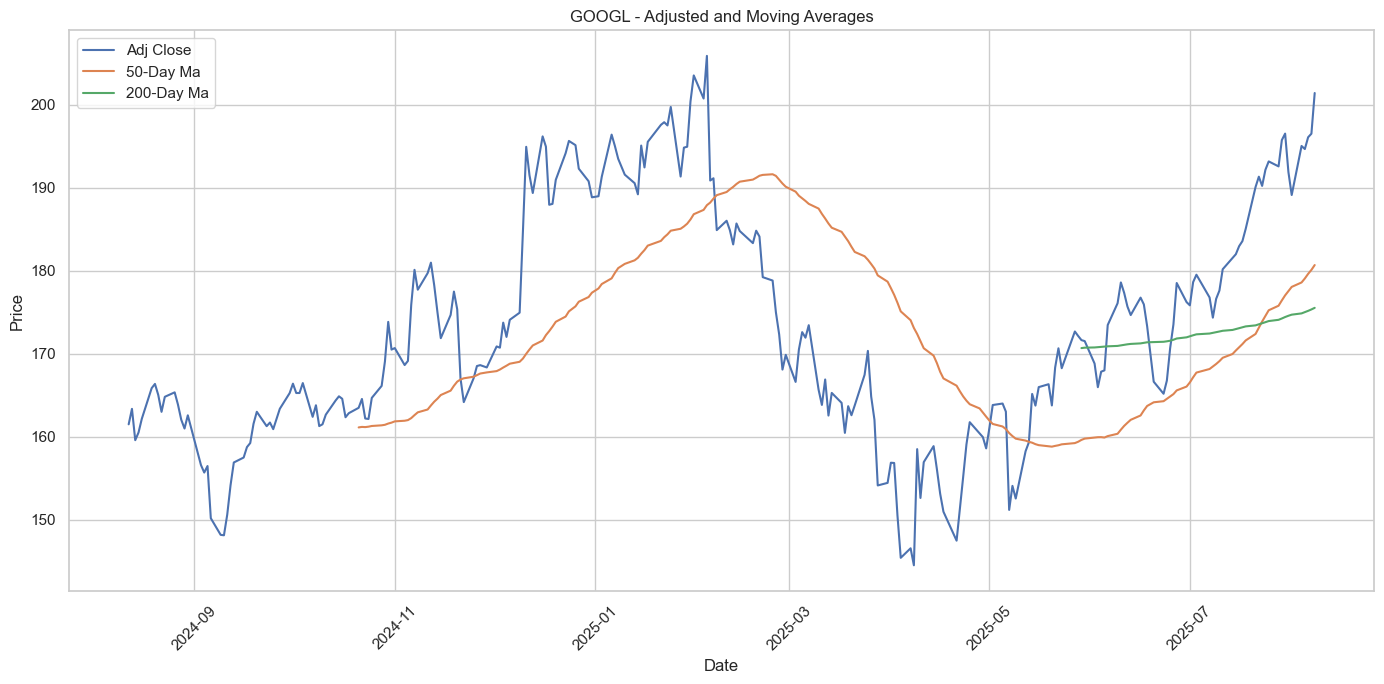

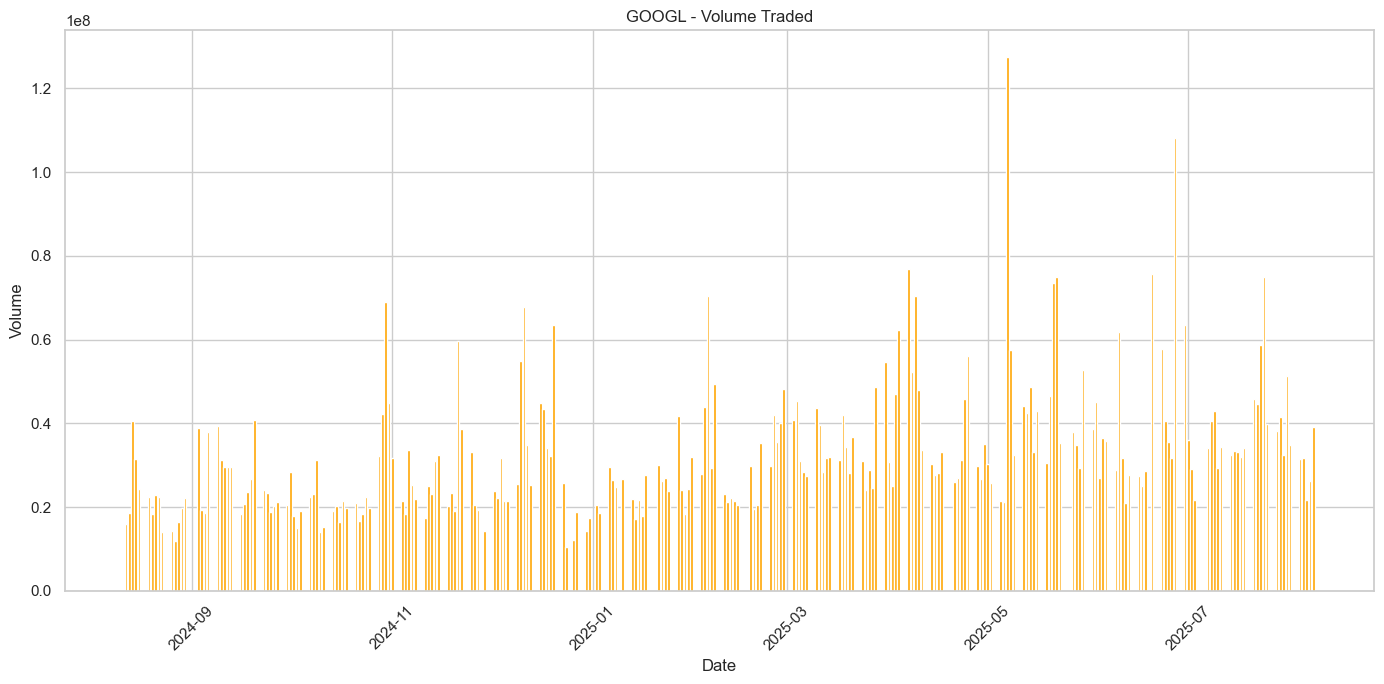

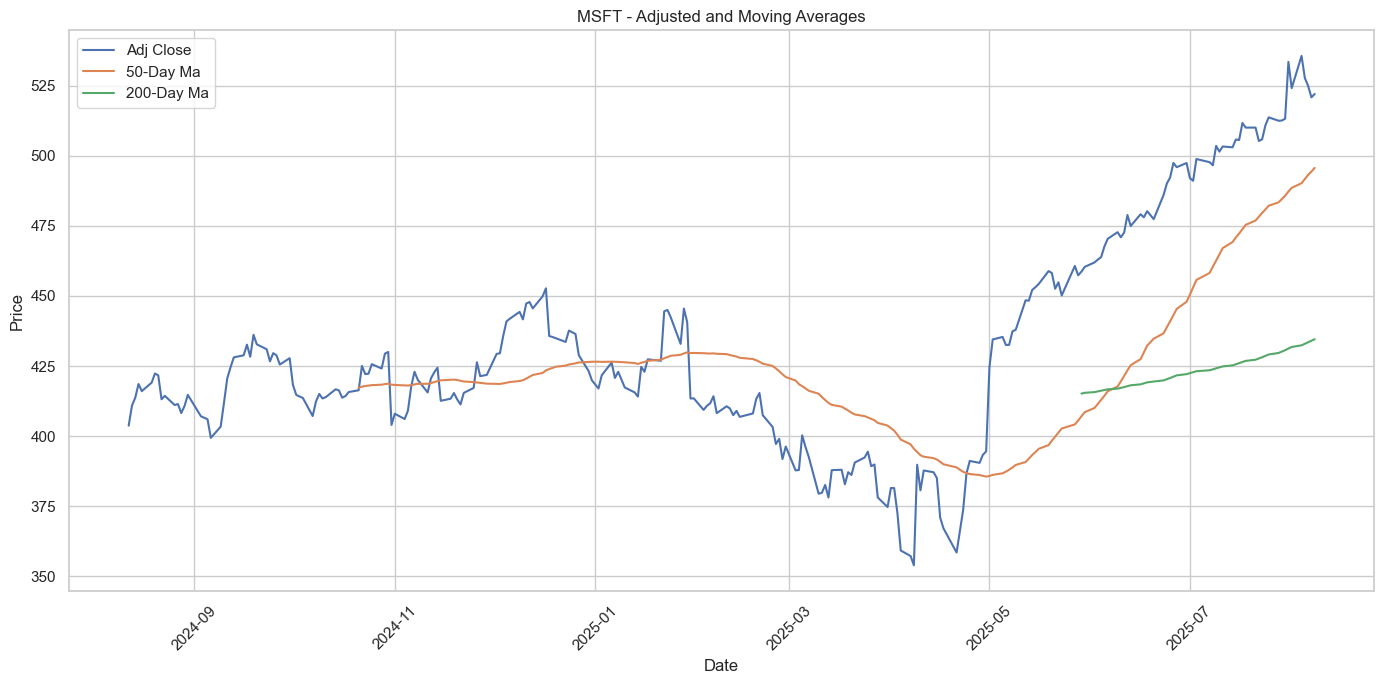

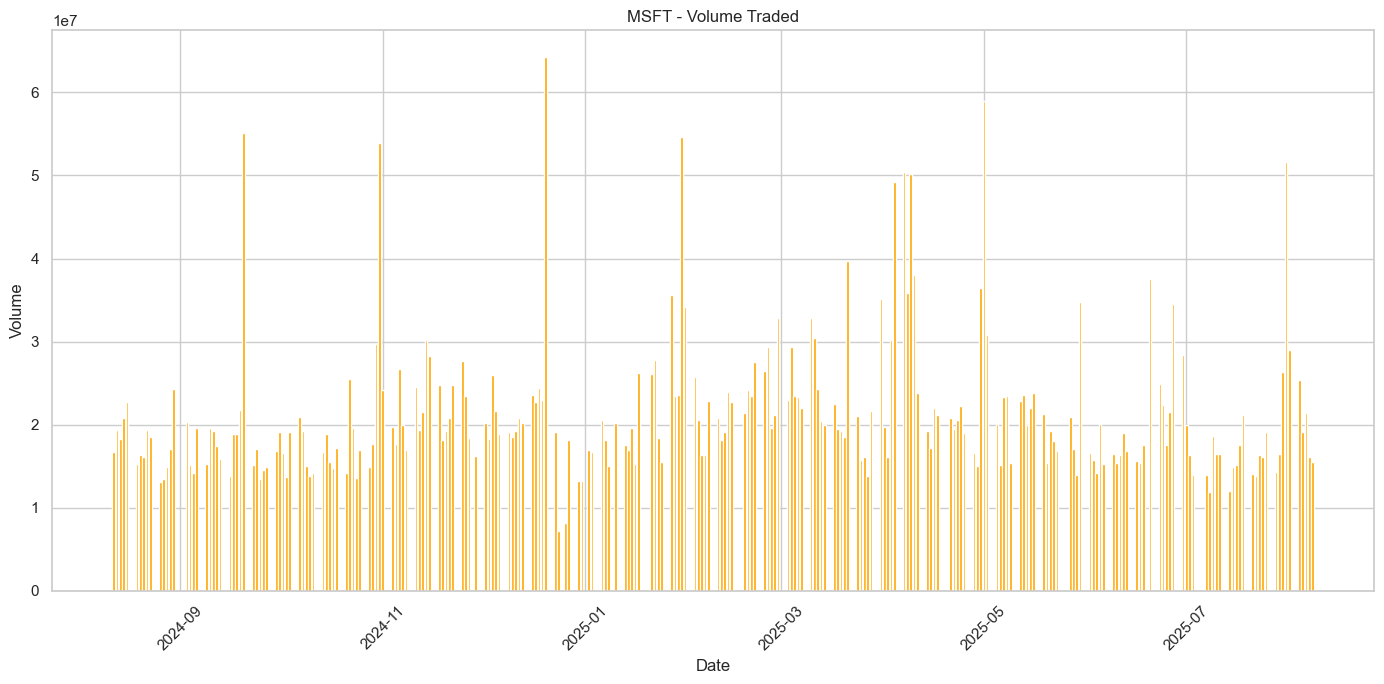

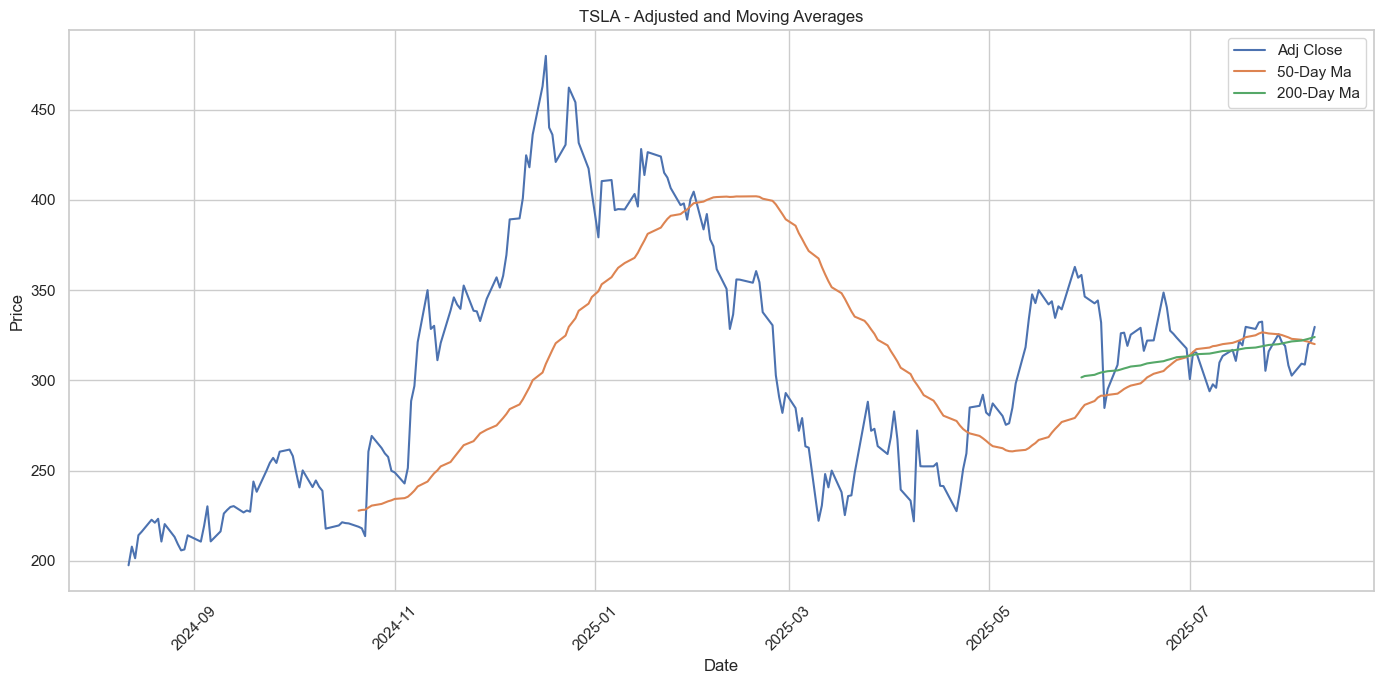

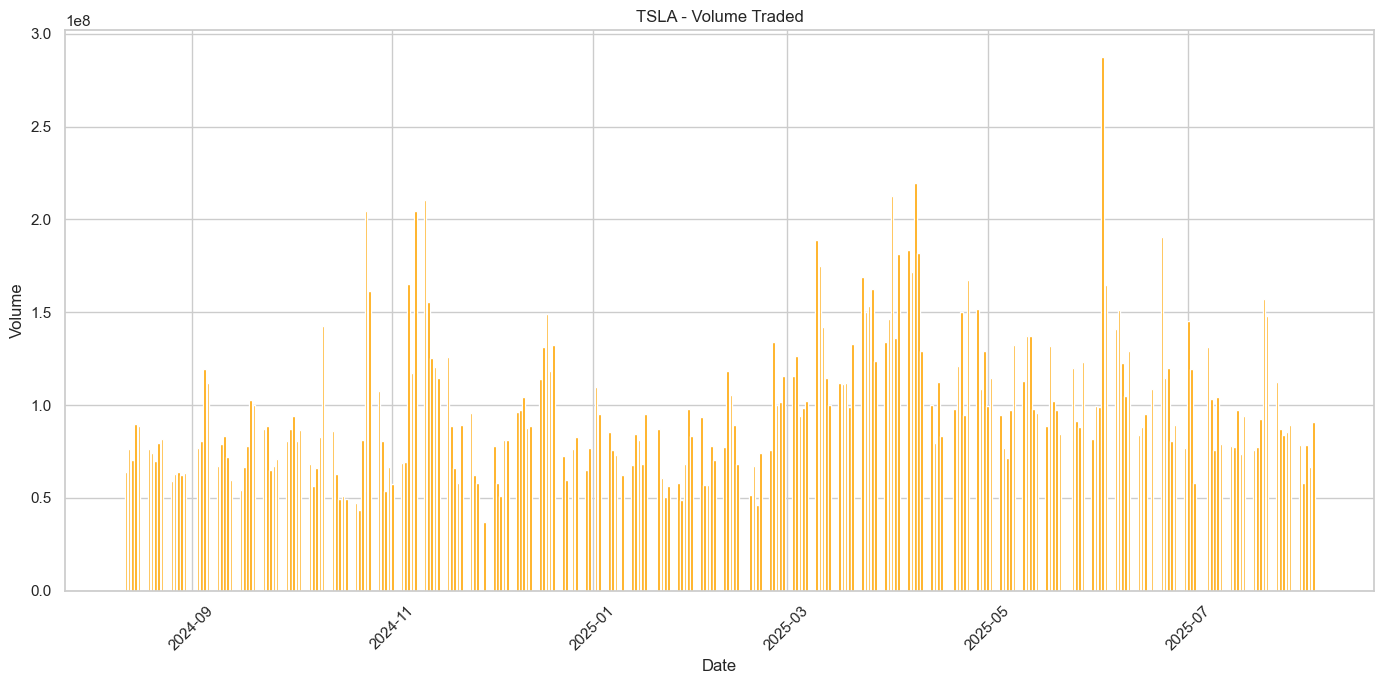

In [75]:
for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA']= ticker_data['Adj Close'].rolling(window=long_window).mean()
    
    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data['Date'], ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data['Date'], ticker_data['50_MA'], label='50-Day Ma')
    plt.plot(ticker_data['Date'], ticker_data['200_MA'], label='200-Day Ma')
    plt.title(f'{ticker} - Adjusted and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data['Date'], ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Distribution of daily returns**

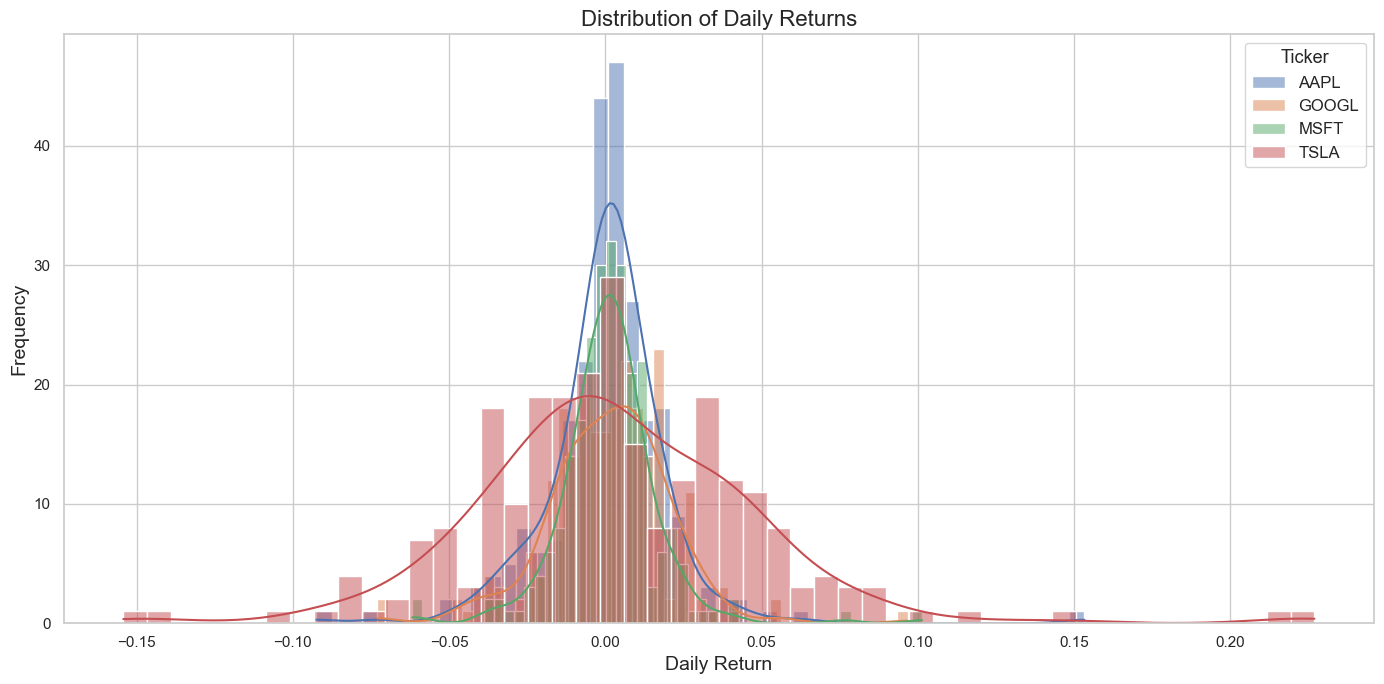

In [76]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set_theme(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)
    
plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='12')
plt.grid(True)
plt.tight_layout()
plt.show()


**Observations** : 

The distributions are approximately normal, centered around zero, which indicates that most daily returns are close to the average return.
However, there are tails on both sides, which reflect **occasional signifcant gains or losses**. **TSLA** and **AAPL** appear to have slighlty wider distributions, which suggests higher volatility compared to MSFT and GOOGL.


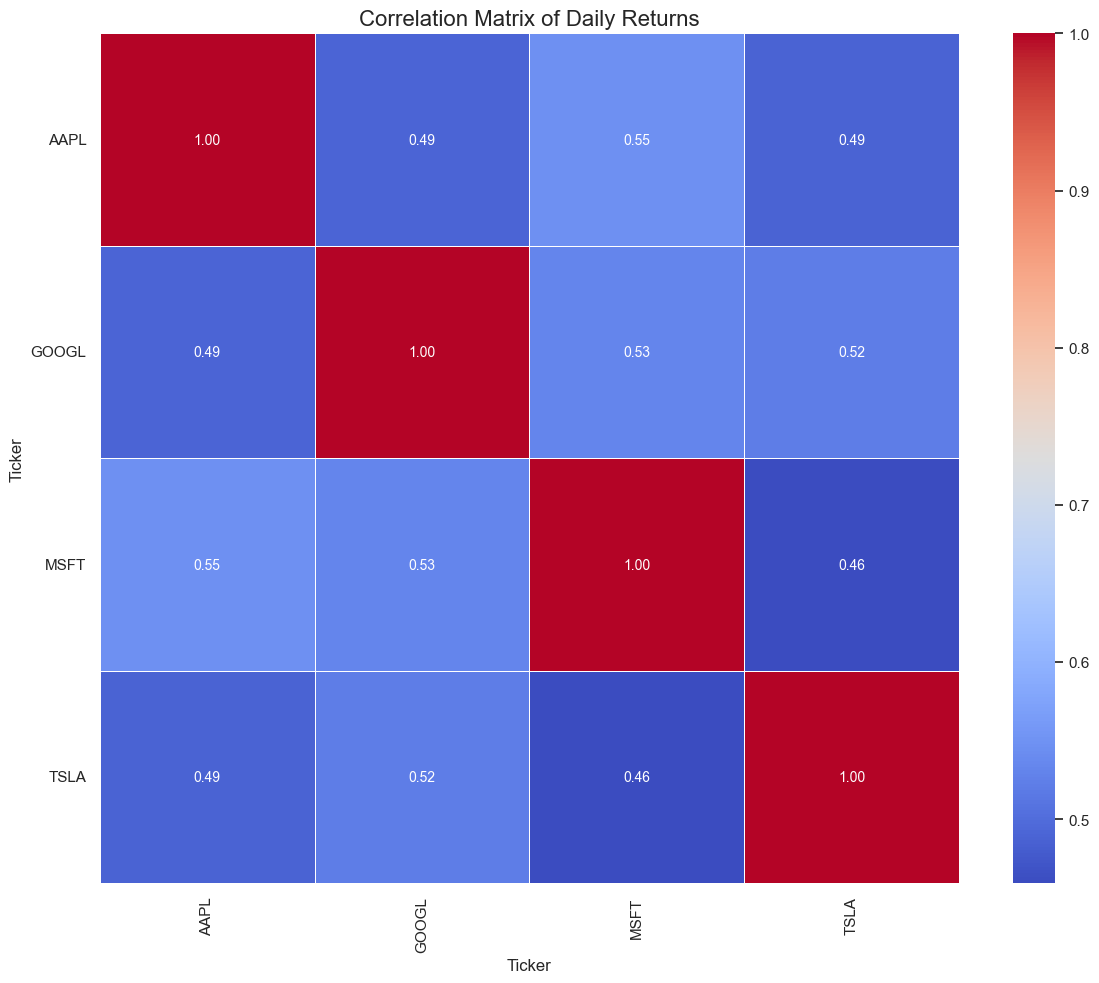

In [77]:
daily_returns = stock_data.pivot(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set_theme(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- All four stocks (AAPL, GOOGL, MSFT, TSLA) show moderate positive correlations in their daily returns, ranging from 0.46 to 0.55.
- The highest correlation is between AAPL and MSFT (0.55), indicating they often move in similar directions.
- TSLA has the lowest correlations with the others, suggesting it offers some diversification benefit within this group.


**Portfolio Optimization**

In [78]:
# Excpected returns and volatility for each stock

excepted_returns = daily_returns.mean() * 252 # Annualized returns
volatility = daily_returns.std() * np.sqrt(252) # Annualized volatility

stock_stats = pd.DataFrame({
    'Expected Return': excepted_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
AAPL,0.108388,0.322126
GOOGL,0.273208,0.312627
MSFT,0.292145,0.249991
TSLA,0.775923,0.722186


*TSLA* has the highest excepected return (77.6%) and high volatility (72.22%)  which indicates a potentially high-reward investment with relatively higher risk. *AAPL* has the lowest excepted return (10.84%) with the highest risk (32.22%) which make sit the least attractive in temrs of risk-adjusted retruns.

*What to tackle next ?*

1. Generate a large number of random portfolio weights.
2.  Calculate the expected return and volatility for each portfolio.
3.  Plot these portfolios to visualize the efficient frontier.

In [79]:
# Portfolio performance
def calculate_portfolio_performance(weights, returns, cov_matrix):
    """
    Calculate the expected return and volatility of a portfolio.
    
    Parameters:
    weights (array): Portfolio weights.
    returns (Series): Expected returns of the assets.
    cov_matrix (DataFrame): Covariance matrix of the asset returns.
    
    Returns:
    tuple: Expected return and volatility of the portfolio.
    """
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility


In [ ]:
# number of portfolios to simulate
num_portfolios = 10000

results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)  

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    
    